In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import altair as alt

from path_explain.path_explainer_tf import PathExplainerTF
from path_explain import utils
from plot.scatter import scatter_plot, _get_bounds
from plot.summary import summary_plot

In [3]:
utils.set_up_environment(visible_devices='0')

In [4]:
n = 5000
d = 5
noise = 0.5
X = np.random.randn(n, d)
y = np.sum(X, axis=-1) + 2 * np.prod(X[:, 0:2], axis=-1)

In [5]:
threshold = int(n * 0.8)
X_train = X[:threshold]
y_train = y[:threshold]
X_test  = X[threshold:]
y_test  = y[threshold:]

In [6]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(d,)))
model.add(tf.keras.layers.Dense(units=10,
                                use_bias=True,
                                activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=5,
                                use_bias=True,
                                activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=1,
                                use_bias=False,
                                activation=None))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [8]:
learning_rate = 0.1
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate),
              loss=tf.keras.losses.MeanSquaredError())

In [9]:
model.fit(X_train, y_train, batch_size=50, epochs=20, verbose=2, validation_split=0.8)

Train on 799 samples, validate on 3201 samples
Epoch 1/20
799/799 - 1s - loss: 6.9013 - val_loss: 5.2410
Epoch 2/20
799/799 - 0s - loss: 4.0805 - val_loss: 2.4461
Epoch 3/20
799/799 - 0s - loss: 2.0919 - val_loss: 1.9388
Epoch 4/20
799/799 - 0s - loss: 1.2135 - val_loss: 0.7538
Epoch 5/20
799/799 - 0s - loss: 1.2273 - val_loss: 0.4399
Epoch 6/20
799/799 - 0s - loss: 0.5853 - val_loss: 0.5953
Epoch 7/20
799/799 - 0s - loss: 1.7505 - val_loss: 0.2419
Epoch 8/20
799/799 - 0s - loss: 0.5886 - val_loss: 0.5856
Epoch 9/20
799/799 - 0s - loss: 0.6268 - val_loss: 0.6563
Epoch 10/20
799/799 - 0s - loss: 0.4031 - val_loss: 0.4204
Epoch 11/20
799/799 - 0s - loss: 0.2693 - val_loss: 0.1645
Epoch 12/20
799/799 - 0s - loss: 0.1957 - val_loss: 0.5912
Epoch 13/20
799/799 - 0s - loss: 0.4246 - val_loss: 0.4810
Epoch 14/20
799/799 - 0s - loss: 0.3631 - val_loss: 0.3655
Epoch 15/20
799/799 - 0s - loss: 0.6280 - val_loss: 0.1799
Epoch 16/20
799/799 - 0s - loss: 0.1613 - val_loss: 0.1751
Epoch 17/20
799/79

In [10]:
model.evaluate(X_test, y_test, batch_size=50, verbose=2)

1000/1000 - 0s - loss: 0.3115


0.3115183562040329

In [11]:
y_test_pred = model.predict(X_test, batch_size=50)

In [12]:
df = pd.DataFrame({
    'Predicted Outcome': y_test_pred[:, 0],
    'True Outcome': y_test
})
alt.Chart(df).mark_point(filled=True, opacity=0.3).encode(
    alt.X('True Outcome:Q'),
    alt.Y('Predicted Outcome:Q')
)

alt.Chart(...)

In [13]:
explainer = PathExplainerTF(model)

In [14]:
feature_values = X_test

## Using Expected Gradients

In [15]:
attributions = explainer.attributions(feature_values.astype(np.float32), X_train.astype(np.float32),
                     batch_size=100, num_samples=100,
                     use_expectation=True, output_indices=[0] * len(feature_values),
                     verbose=True)

100%|██████████| 1000/1000 [00:05<00:00, 194.53it/s]


In [16]:
interactions = explainer.interactions(feature_values.astype(np.float32), X_train.astype(np.float32),
                         batch_size=100, num_samples=100,
                         use_expectation=True, output_indices=[0] * len(feature_values),
                         verbose=True, interaction_index=None)

100%|██████████| 1000/1000 [04:26<00:00,  3.75it/s]


In [17]:
data_df = pd.DataFrame({
    'Attributions': attributions.flatten(),
    'Sum of Interactions': np.sum(interactions, axis=-1).flatten()
})
alt.Chart(data_df).mark_point().encode(
    alt.X('Attributions:Q'),
    alt.Y('Sum of Interactions')
)

alt.Chart(...)

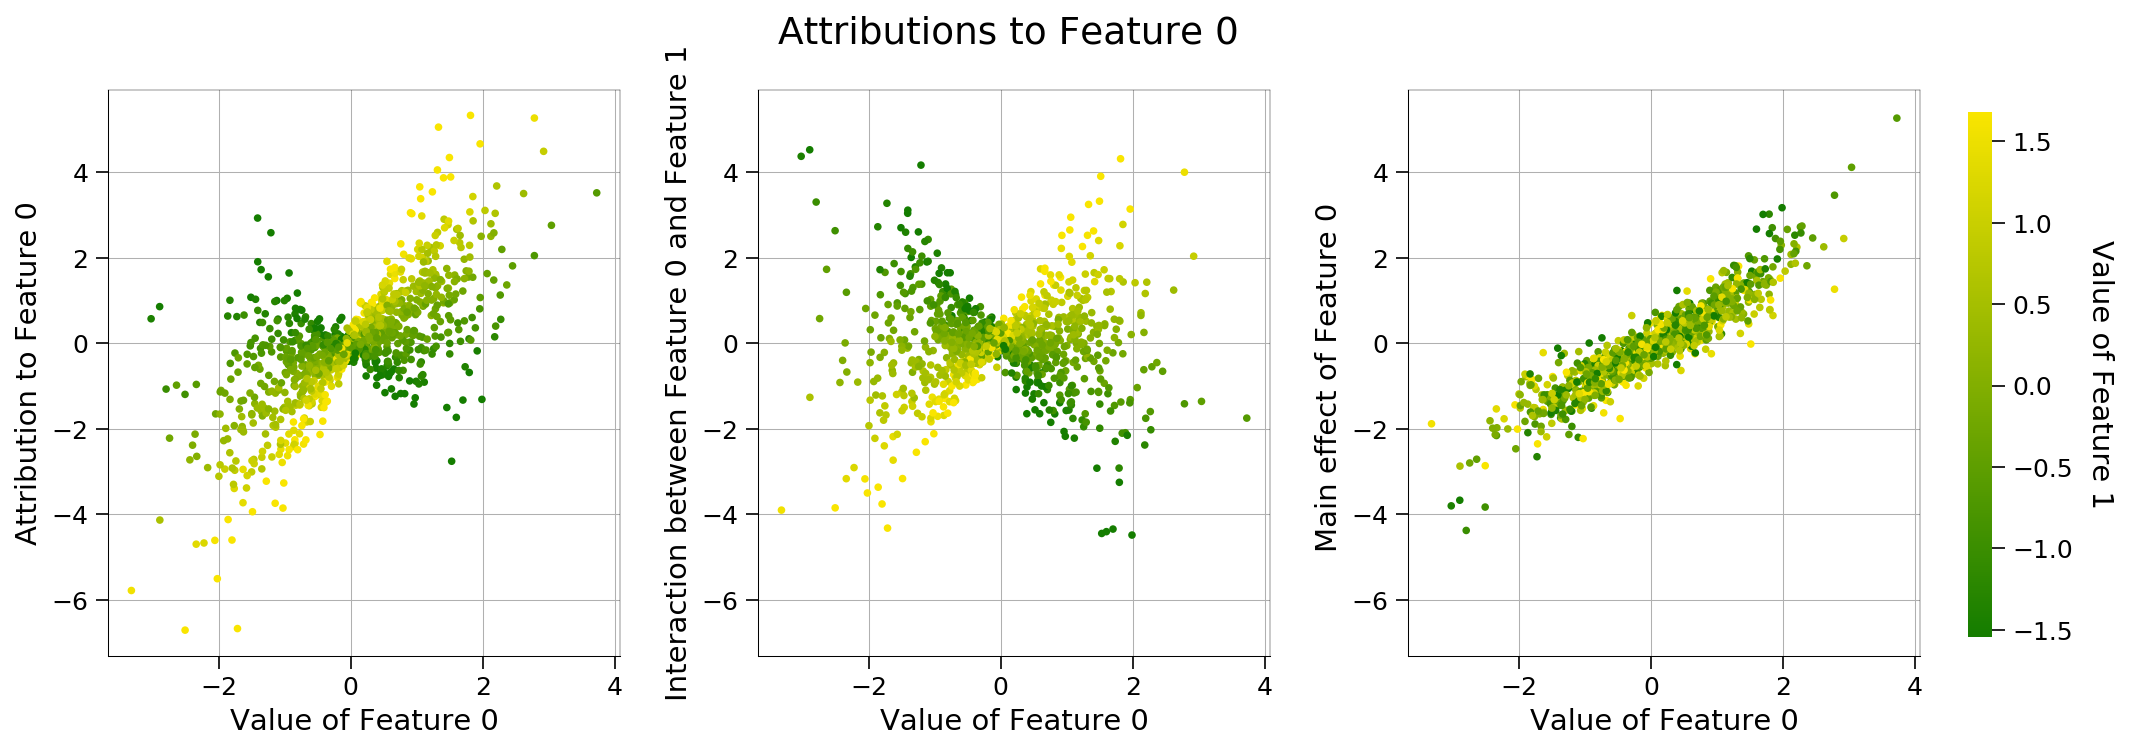

In [18]:
fig, axs = scatter_plot(attributions,
             feature_values,
             feature_index=0,
             interactions=interactions,
             color_by=1,
             feature_names=None)

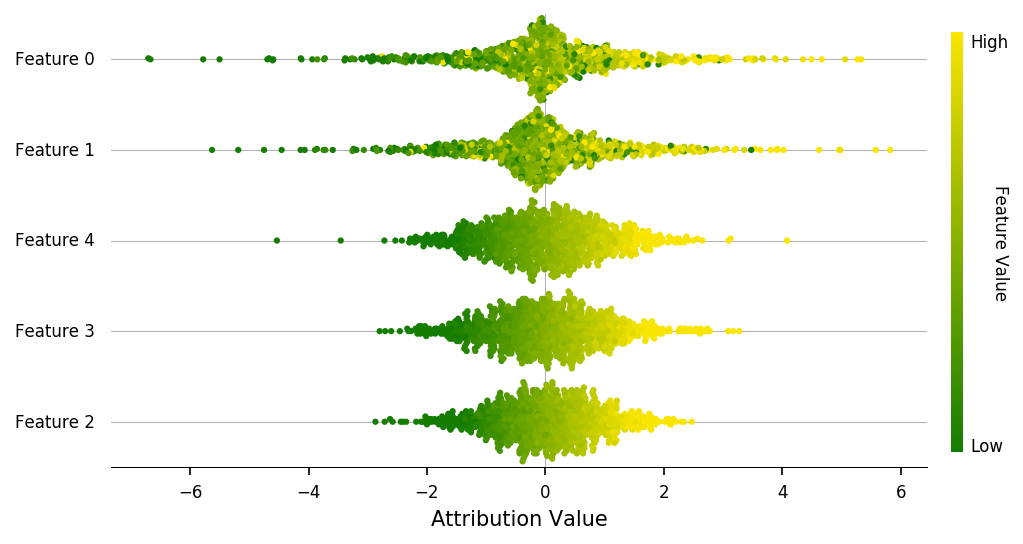

In [19]:
summary_plot(attributions,
             feature_values,
             interactions=None,
             interaction_feature=None,
             feature_names=None,
             plot_top_k=None)

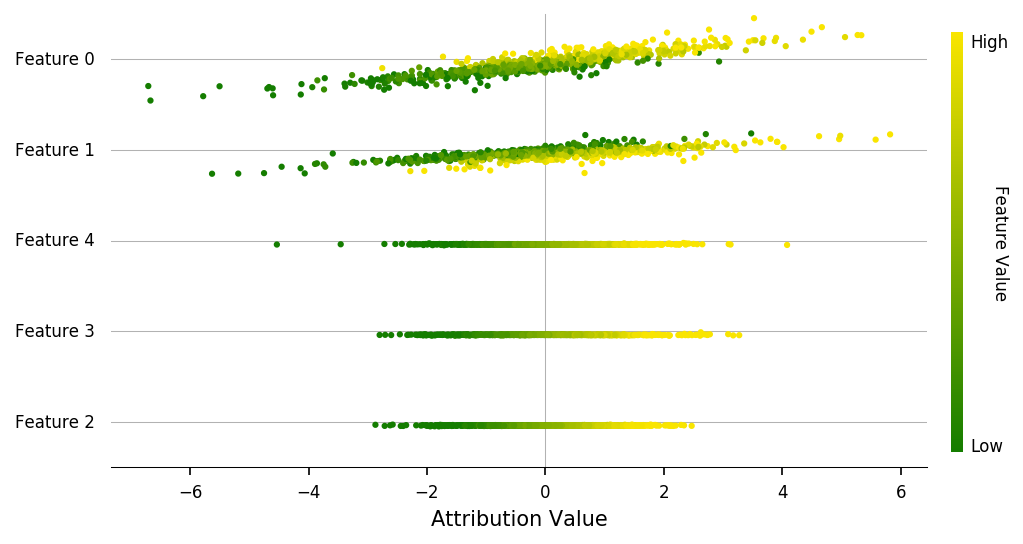

In [20]:
summary_plot(attributions,
             feature_values,
             interactions=interactions,
             interaction_feature=0,
             feature_names=None,
             plot_top_k=None)

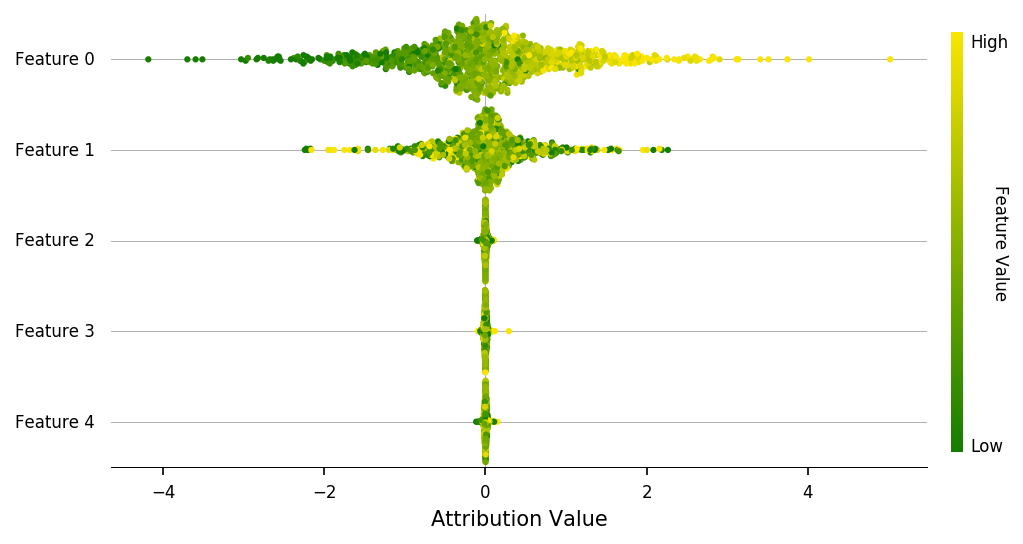

In [21]:
summary_plot(interactions[:, 0],
             feature_values,
             interactions=None,
             interaction_feature=None,
             feature_names=None,
             plot_top_k=None)